# ファルマコフォア (Pharmacophore)

## 概要

ファルマコフォアは、分子が生物学的活性を示すために必要な立体配置された化学的特徴の集合を表現したモデルです。本ノートブックでは、ファルマコフォアの概念から実際のモデル構築、そして創薬への応用まで包括的に学習します。

## 学習目標

- ファルマコフォアの概念と創薬における重要性を理解する
- 化学的特徴点（Feature Points）の種類と定義を学ぶ
- ファルマコフォアモデルの構築方法を習得する
- 既知活性化合物からの共通構造抽出を実装する
- ファルマコフォアベースの仮想スクリーニングを実践する
- 3D薬理活性モデルの可視化と解析手法を理解する

## 補助資料

**初心者の方へ**: この内容が難しく感じる場合は、以下の補助資料をご参照ください：

- **[ファルマコフォア 初心者ガイド](../pharmacophore-beginner-guide/)**: 基本概念を日常的な例えで解説
- **[ファルマコフォア 用語集](../pharmacophore-glossary/)**: 専門用語の分かりやすい説明と参考リンク

これらの資料は、文系出身の方や化学・情報学の予備知識が少ない方でも理解できるよう工夫されています。

## ダウンロード

<a class="link" href="/files/pharmacophore_executed.ipynb" download>📓 実行済みノートブックをダウンロード</a>

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Crippen
from rdkit.Chem import Draw, rdDepictor, rdMolAlign
from rdkit.Geometry import Point3D
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')

# ファルマコフォア関連の機能をインポート
try:
    from rdkit.Chem import ChemicalFeatures
    from rdkit.Chem.Features import FeatureFactory
    HAS_PHARMACOPHORE = True
except ImportError:
    print("Warning: RDKit pharmacophore features not available. Using alternative approach.")
    HAS_PHARMACOPHORE = False

# py3Dmolのインポート（表示用）
try:
    import py3Dmol
    HAS_PY3DMOL = True
except ImportError:
    try:
        import py3dmol as py3Dmol
        HAS_PY3DMOL = True
    except ImportError:
        HAS_PY3DMOL = False
        print("Warning: py3Dmol not available. 3D visualization will be limited.")

# 日本語フォントの設定
plt.rcParams['font.family'] = "Noto Sans CJK JP"
sns.set_style("whitegrid")

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


## 1. ファルマコフォアの基本概念

ファルマコフォアは、Paul Ehrlichによって1909年に提唱された概念で、「薬理活性に必要な分子認識の抽象的記述」として定義されます。現代では、分子の生物学的活性に必要な3次元的に配置された化学的特徴の集合として理解されています。

In [2]:
# ファルマコフォア特徴点の定義
class PharmacophoreFeatures:
    """ファルマコフォア特徴点の定義クラス"""
    
    FEATURE_TYPES = {
        'Donor': '水素結合供与体',
        'Acceptor': '水素結合受容体', 
        'Aromatic': '芳香環',
        'Hydrophobic': '疎水性領域',
        'PosIonizable': '正イオン化可能基',
        'NegIonizable': '負イオン化可能基',
        'LumpedHydrophobe': '疎水性クラスター',
        'ZnBinder': '亜鉛結合基'
    }
    
    @classmethod
    def get_feature_description(cls):
        """特徴点の説明を返す"""
        return cls.FEATURE_TYPES

# ファルマコフォア特徴点の説明
print("ファルマコフォア特徴点の種類:")
print("=" * 50)
for code, description in PharmacophoreFeatures.get_feature_description().items():
    print(f"{code:15}: {description}")

ファルマコフォア特徴点の種類:
Donor          : 水素結合供与体
Acceptor       : 水素結合受容体
Aromatic       : 芳香環
Hydrophobic    : 疎水性領域
PosIonizable   : 正イオン化可能基
NegIonizable   : 負イオン化可能基
LumpedHydrophobe: 疎水性クラスター
ZnBinder       : 亜鉛結合基


## 2. 化学的特徴点の抽出

RDKitを使用して分子から化学的特徴点を自動抽出します。これらの特徴点がファルマコフォアモデルの基礎となります。

In [3]:
# 特徴点抽出器の設定
def setup_feature_factory():
    """RDKitの特徴点抽出器を設定（代替実装）"""
    if HAS_PHARMACOPHORE:
        try:
            feature_factory = ChemicalFeatures.BuildFeatureFactory('MinimalFeatures.fdef')
            return feature_factory
        except:
            pass
    return None

def extract_features_alternative(mol):
    """分子から化学的特徴点を代替方法で抽出"""
    if mol is None:
        return []
    
    # 3D座標の生成
    mol_copy = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol_copy, randomSeed=42)
    AllChem.UFFOptimizeMolecule(mol_copy)
    
    feature_data = []
    
    # 基本的な化学的特徴を手動で検出
    # 水素結合供与体（N-H, O-H）
    donor_pattern = Chem.MolFromSmarts('[!#6;!#1;!H0]')
    donors = mol_copy.GetSubstructMatches(donor_pattern)
    for donor in donors:
        atom = mol_copy.GetAtomWithIdx(donor[0])
        conf = mol_copy.GetConformer()
        pos = conf.GetAtomPosition(donor[0])
        feature_data.append({
            'type': 'Donor',
            'family': 'Donor',
            'position': pos,
            'atom_ids': [donor[0]]
        })
    
    # 水素結合受容体（N, O with lone pairs）
    acceptor_pattern = Chem.MolFromSmarts('[!$([#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]')
    acceptors = mol_copy.GetSubstructMatches(acceptor_pattern)
    for acceptor in acceptors:
        atom = mol_copy.GetAtomWithIdx(acceptor[0])
        conf = mol_copy.GetConformer()
        pos = conf.GetAtomPosition(acceptor[0])
        feature_data.append({
            'type': 'Acceptor',
            'family': 'Acceptor', 
            'position': pos,
            'atom_ids': [acceptor[0]]
        })
    
    # 芳香環
    aromatic_rings = Chem.GetSymmSSSR(mol_copy)
    for ring in aromatic_rings:
        # リング内の原子がすべて芳香族かチェック
        if all(mol_copy.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring):
            # リングの中心座標を計算
            conf = mol_copy.GetConformer()
            center_x = sum(conf.GetAtomPosition(idx).x for idx in ring) / len(ring)
            center_y = sum(conf.GetAtomPosition(idx).y for idx in ring) / len(ring)
            center_z = sum(conf.GetAtomPosition(idx).z for idx in ring) / len(ring)
            
            # Point3Dオブジェクトの代替
            class SimplePoint3D:
                def __init__(self, x, y, z):
                    self.x = x
                    self.y = y
                    self.z = z
            
            feature_data.append({
                'type': 'Aromatic',
                'family': 'Aromatic',
                'position': SimplePoint3D(center_x, center_y, center_z),
                'atom_ids': list(ring)
            })
    
    # 疎水性原子（炭素）
    hydrophobic_pattern = Chem.MolFromSmarts('[#6]')
    hydrophobes = mol_copy.GetSubstructMatches(hydrophobic_pattern)
    for hydrophobe in hydrophobes:
        atom = mol_copy.GetAtomWithIdx(hydrophobe[0])
        # 極性原子に結合していない炭素のみ
        neighbors = [mol_copy.GetAtomWithIdx(x.GetIdx()) for x in atom.GetNeighbors()]
        if not any(n.GetAtomicNum() in [7, 8, 16] for n in neighbors):
            conf = mol_copy.GetConformer()
            pos = conf.GetAtomPosition(hydrophobe[0])
            feature_data.append({
                'type': 'Hydrophobic',
                'family': 'Hydrophobic',
                'position': pos,
                'atom_ids': [hydrophobe[0]]
            })
    
    return feature_data, mol_copy

def extract_features(mol, feature_factory=None):
    """分子から化学的特徴点を抽出"""
    if feature_factory is not None and HAS_PHARMACOPHORE:
        try:
            # 3D座標の生成
            mol_copy = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_copy, randomSeed=42)
            AllChem.UFFOptimizeMolecule(mol_copy)
            
            # 特徴点の抽出
            features = feature_factory.GetFeaturesForMol(mol_copy)
            
            feature_data = []
            for feature in features:
                feature_info = {
                    'type': feature.GetType(),
                    'family': feature.GetFamily(),
                    'position': feature.GetPos(),
                    'atom_ids': list(feature.GetAtomIds())
                }
                feature_data.append(feature_info)
            
            return feature_data, mol_copy
        except:
            pass
    
    # 代替実装を使用
    return extract_features_alternative(mol)

# テスト用分子での特徴点抽出
test_molecules = {
    "アスピリン": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "イブプロフェン": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O", 
    "ナプロキセン": "COC1=CC=CC2=C1C=C(C=C2)C(C)C(=O)O",
    "インドメタシン": "CC1=C(C2=CC=CC=C2N1C(=O)C3=CC=C(C=C3)Cl)CC(=O)O"
}

# 特徴点抽出器の初期化
feature_factory = setup_feature_factory()

print("分子の化学的特徴点抽出:")
print("=" * 60)

molecule_features = {}
for name, smiles in test_molecules.items():
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        features, mol_3d = extract_features(mol, feature_factory)
        molecule_features[name] = {
            'features': features,
            'mol_3d': mol_3d,
            'smiles': smiles
        }
        
        print(f"\n{name} ({smiles}):")
        print(f"  総特徴点数: {len(features)}")
        
        # 特徴点の種類別カウント
        feature_counts = {}
        for feature in features:
            ftype = feature['family']
            feature_counts[ftype] = feature_counts.get(ftype, 0) + 1
        
        for ftype, count in sorted(feature_counts.items()):
            description = PharmacophoreFeatures.FEATURE_TYPES.get(ftype, ftype)
            print(f"    {ftype} ({description}): {count}")

分子の化学的特徴点抽出:

アスピリン (CC(=O)OC1=CC=CC=C1C(=O)O):
  総特徴点数: 20
    Acceptor (水素結合受容体): 12
    Aromatic (芳香環): 1
    Donor (水素結合供与体): 1
    Hydrophobic (疎水性領域): 6

イブプロフェン (CC(C)CC1=CC=C(C=C1)C(C)C(=O)O):
  総特徴点数: 34
    Acceptor (水素結合受容体): 20
    Aromatic (芳香環): 1
    Donor (水素結合供与体): 1
    Hydrophobic (疎水性領域): 12

ナプロキセン (COC1=CC=CC2=C1C=C(C=C2)C(C)C(=O)O):
  総特徴点数: 31
    Acceptor (水素結合受容体): 17
    Aromatic (芳香環): 2
    Donor (水素結合供与体): 1
    Hydrophobic (疎水性領域): 11

インドメタシン (CC1=C(C2=CC=CC=C2N1C(=O)C3=CC=C(C=C3)Cl)CC(=O)O):
  総特徴点数: 35
    Acceptor (水素結合受容体): 17
    Aromatic (芳香環): 3
    Donor (水素結合供与体): 1
    Hydrophobic (疎水性領域): 14


## 3. ファルマコフォアモデルの構築

複数の活性化合物から共通の化学的特徴を抽出し、ファルマコフォアモデルを構築します。これにより、活性に必要な重要な特徴を特定できます。

In [4]:
def calculate_feature_distances(features):
    """特徴点間距離を計算"""
    if len(features) < 2:
        return []
    
    distances = []
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            feat1 = features[i]
            feat2 = features[j]
            
            pos1 = feat1['position']
            pos2 = feat2['position']
            
            # 3D距離の計算
            distance = np.sqrt(
                (pos1.x - pos2.x)**2 + 
                (pos1.y - pos2.y)**2 + 
                (pos1.z - pos2.z)**2
            )
            
            distances.append({
                'feature1': feat1,
                'feature2': feat2,
                'distance': distance,
                'type_pair': (feat1['family'], feat2['family'])
            })
    
    return distances

def find_common_pharmacophore(molecule_features_dict, distance_tolerance=2.0):
    """複数分子から共通ファルマコフォアを抽出"""
    all_distances = {}
    
    # 各分子の特徴点間距離を計算
    for mol_name, mol_data in molecule_features_dict.items():
        distances = calculate_feature_distances(mol_data['features'])
        all_distances[mol_name] = distances
    
    # 共通の特徴点ペアを検索
    common_patterns = []
    
    if len(all_distances) < 2:
        return common_patterns
    
    # 最初の分子を基準とする
    reference_mol = list(all_distances.keys())[0]
    reference_distances = all_distances[reference_mol]
    
    for ref_dist in reference_distances:
        ref_type_pair = ref_dist['type_pair']
        ref_distance = ref_dist['distance']
        
        # 他の分子で同様のパターンを検索
        matching_molecules = [reference_mol]
        
        for mol_name, distances in all_distances.items():
            if mol_name == reference_mol:
                continue
                
            for dist in distances:
                if (dist['type_pair'] == ref_type_pair or 
                    dist['type_pair'] == (ref_type_pair[1], ref_type_pair[0])):
                    if abs(dist['distance'] - ref_distance) <= distance_tolerance:
                        matching_molecules.append(mol_name)
                        break
        
        # 半数以上の分子で共通している場合
        if len(matching_molecules) >= len(all_distances) // 2 + 1:
            common_patterns.append({
                'type_pair': ref_type_pair,
                'distance': ref_distance,
                'matching_molecules': matching_molecules,
                'occurrence': len(matching_molecules)
            })
    
    return common_patterns

# 共通ファルマコフォアの抽出
print("\n共通ファルマコフォアパターンの抽出:")
print("=" * 60)

common_pharmacophore = find_common_pharmacophore(molecule_features)

# 結果の表示
if common_pharmacophore:
    print(f"発見された共通パターン数: {len(common_pharmacophore)}")
    print("\n共通パターンの詳細:")
    
    for i, pattern in enumerate(common_pharmacophore, 1):
        type1, type2 = pattern['type_pair']
        desc1 = PharmacophoreFeatures.FEATURE_TYPES.get(type1, type1)
        desc2 = PharmacophoreFeatures.FEATURE_TYPES.get(type2, type2)
        
        print(f"\nパターン {i}:")
        print(f"  特徴点ペア: {type1} ({desc1}) - {type2} ({desc2})")
        print(f"  距離: {pattern['distance']:.2f} Å")
        print(f"  出現頻度: {pattern['occurrence']}/{len(molecule_features)} 分子")
        print(f"  該当分子: {', '.join(pattern['matching_molecules'])}")
else:
    print("共通パターンが見つかりませんでした")


共通ファルマコフォアパターンの抽出:
発見された共通パターン数: 190

共通パターンの詳細:

パターン 1:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 6.22 Å
  出現頻度: 4/4 分子
  該当分子: アスピリン, イブプロフェン, ナプロキセン, インドメタシン

パターン 2:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 4.29 Å
  出現頻度: 4/4 分子
  該当分子: アスピリン, イブプロフェン, ナプロキセン, インドメタシン

パターン 3:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 2.29 Å
  出現頻度: 4/4 分子
  該当分子: アスピリン, イブプロフェン, ナプロキセン, インドメタシン

パターン 4:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 0.00 Å
  出現頻度: 4/4 分子
  該当分子: アスピリン, イブプロフェン, ナプロキセン, インドメタシン

パターン 5:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 7.50 Å
  出現頻度: 4/4 分子
  該当分子: アスピリン, イブプロフェン, ナプロキセン, インドメタシン

パターン 6:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 6.33 Å
  出現頻度: 4/4 分子
  該当分子: アスピリン, イブプロフェン, ナプロキセン, インドメタシン

パターン 7:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 6.51 Å
  出現頻度: 4/4 分子
  該当分子: アスピリン, イブプロフェン, ナプロキセン, インドメタシン

パターン 8:
  特徴点ペア: Donor (水素結合供与体) - Acceptor (水素結合受容体)
  距離: 5.91 Å
  出現頻度: 4/4 分子
  該当分子

## 4. ファルマコフォアの可視化

抽出されたファルマコフォアパターンを3D空間で可視化し、分子の重ね合わせによる構造解析を行います。

In [5]:
def visualize_molecule_features(mol_data, molecule_name):
    """分子の特徴点を可視化"""
    if not HAS_PY3DMOL:
        print("py3Dmol が利用できないため、2D構造を表示します")
        mol_2d = Chem.MolFromSmiles(mol_data['smiles'])
        return Draw.MolToImage(mol_2d, size=(400, 400))
    
    mol_3d = mol_data['mol_3d']
    features = mol_data['features']
    
    # 3D表示の準備
    mol_block = Chem.MolToMolBlock(mol_3d)
    
    viewer = py3Dmol.view(width=500, height=400)
    viewer.addModel(mol_block, 'mol')
    viewer.setStyle({'stick': {}})
    
    # 特徴点の追加
    colors = {
        'Donor': 'blue',
        'Acceptor': 'red', 
        'Aromatic': 'orange',
        'Hydrophobic': 'green',
        'PosIonizable': 'purple',
        'NegIonizable': 'yellow'
    }
    
    for feature in features:
        pos = feature['position']
        color = colors.get(feature['family'], 'gray')
        
        viewer.addSphere({
            'center': {'x': pos.x, 'y': pos.y, 'z': pos.z},
            'radius': 0.5,
            'color': color,
            'alpha': 0.7
        })
    
    viewer.zoomTo()
    return viewer

# 分子の3D可視化（最初の2分子）
print("\n分子の3D構造と特徴点:")
print("=" * 40)

for i, (name, mol_data) in enumerate(list(molecule_features.items())[:2]):
    print(f"\n{name}の3D構造と特徴点:")
    result = visualize_molecule_features(mol_data, name)
    if HAS_PY3DMOL:
        result.show()
    else:
        # 2D構造の表示情報
        print(f"  分子式: {Chem.rdMolDescriptors.CalcMolFormula(Chem.MolFromSmiles(mol_data['smiles']))}")
        print(f"  特徴点数: {len(mol_data['features'])}")


分子の3D構造と特徴点:

アスピリンの3D構造と特徴点:
py3Dmol が利用できないため、2D構造を表示します
  分子式: C9H8O4
  特徴点数: 20

イブプロフェンの3D構造と特徴点:
py3Dmol が利用できないため、2D構造を表示します
  分子式: C13H18O2
  特徴点数: 34


## 5. 特徴点の統計解析

抽出された特徴点の分布と出現頻度を統計的に解析し、各特徴点の重要性を評価します。

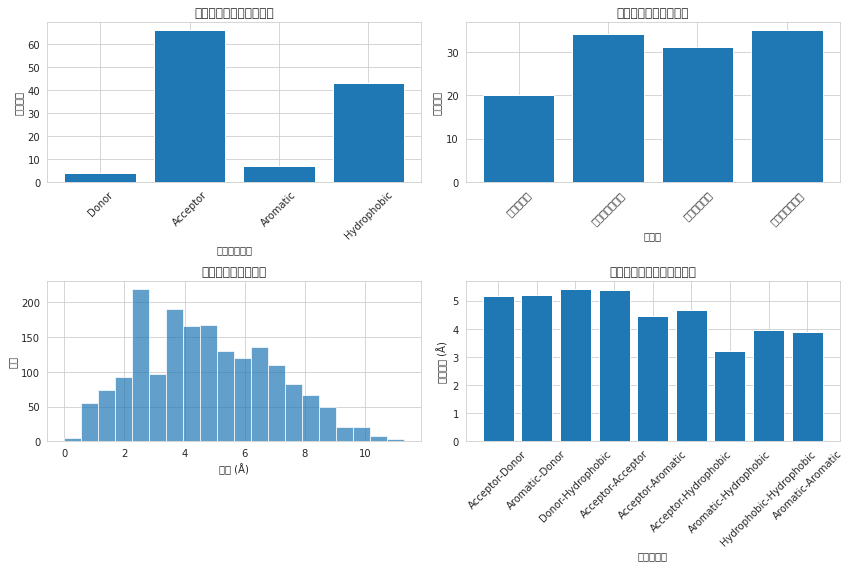


特徴点統計サマリー:
総特徴点数: 120
分子数: 4
平均特徴点数/分子: 30.0

特徴点タイプ別出現頻度:
  Acceptor (水素結合受容体): 66 (55.0%)
  Hydrophobic (疎水性領域): 43 (35.8%)
  Aromatic (芳香環): 7 (5.8%)
  Donor (水素結合供与体): 4 (3.3%)


In [6]:
# 特徴点の統計解析
def analyze_feature_statistics(molecule_features_dict):
    """特徴点の統計解析"""
    all_features = []
    feature_counts = {}
    distance_stats = {}
    
    # 全分子の特徴点を収集
    for mol_name, mol_data in molecule_features_dict.items():
        for feature in mol_data['features']:
            all_features.append({
                'molecule': mol_name,
                'type': feature['family'],
                'position': feature['position']
            })
            
            # タイプ別カウント
            ftype = feature['family']
            feature_counts[ftype] = feature_counts.get(ftype, 0) + 1
    
    # 距離統計の計算
    for mol_name, mol_data in molecule_features_dict.items():
        distances = calculate_feature_distances(mol_data['features'])
        
        for dist_info in distances:
            type_pair = tuple(sorted(dist_info['type_pair']))
            distance = dist_info['distance']
            
            if type_pair not in distance_stats:
                distance_stats[type_pair] = []
            distance_stats[type_pair].append(distance)
    
    return all_features, feature_counts, distance_stats

# 統計解析の実行
all_features, feature_counts, distance_stats = analyze_feature_statistics(molecule_features)

# 特徴点出現頻度の可視化
plt.figure(figsize=(12, 8))

# 特徴点タイプの出現頻度
plt.subplot(2, 2, 1)
types = list(feature_counts.keys())
counts = list(feature_counts.values())
plt.bar(types, counts)
plt.title('特徴点タイプの出現頻度')
plt.xlabel('特徴点タイプ')
plt.ylabel('出現回数')
plt.xticks(rotation=45)

# 分子あたりの特徴点数
plt.subplot(2, 2, 2)
mol_feature_counts = []
mol_names = []
for mol_name, mol_data in molecule_features.items():
    mol_feature_counts.append(len(mol_data['features']))
    mol_names.append(mol_name)

plt.bar(mol_names, mol_feature_counts)
plt.title('分子あたりの特徴点数')
plt.xlabel('分子名')
plt.ylabel('特徴点数')
plt.xticks(rotation=45)

# 特徴点間距離の分布
plt.subplot(2, 2, 3)
all_distances = []
for distances in distance_stats.values():
    all_distances.extend(distances)

if all_distances:
    plt.hist(all_distances, bins=20, alpha=0.7)
    plt.title('特徴点間距離の分布')
    plt.xlabel('距離 (Å)')
    plt.ylabel('頻度')

# 主要な特徴点ペアの平均距離
plt.subplot(2, 2, 4)
if distance_stats:
    pair_names = []
    mean_distances = []
    
    for pair, distances in distance_stats.items():
        if len(distances) >= 2:  # 複数のデータがある場合のみ
            pair_names.append(f"{pair[0]}-{pair[1]}")
            mean_distances.append(np.mean(distances))
    
    if pair_names:
        plt.bar(pair_names, mean_distances)
        plt.title('主要特徴点ペアの平均距離')
        plt.xlabel('特徴点ペア')
        plt.ylabel('平均距離 (Å)')
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 統計サマリーの表示
print("\n特徴点統計サマリー:")
print("=" * 50)
print(f"総特徴点数: {len(all_features)}")
print(f"分子数: {len(molecule_features)}")
print(f"平均特徴点数/分子: {len(all_features)/len(molecule_features):.1f}")

print("\n特徴点タイプ別出現頻度:")
for ftype, count in sorted(feature_counts.items(), key=lambda x: x[1], reverse=True):
    description = PharmacophoreFeatures.FEATURE_TYPES.get(ftype, ftype)
    percentage = (count / len(all_features)) * 100
    print(f"  {ftype} ({description}): {count} ({percentage:.1f}%)")

## 6. ファルマコフォアベースの仮想スクリーニング

構築したファルマコフォアモデルを用いて、化合物データベースから類似の活性を持つ可能性のある化合物を検索します。

In [7]:
# 仮想スクリーニング用のテスト化合物データベース
screening_database = {
    "化合物A": "CC1=CC=C(C=C1)C(=O)O",  # 安息香酸誘導体
    "化合物B": "COC1=CC=C(C=C1)C(=O)O",  # メトキシ安息香酸
    "化合物C": "CC(C)C1=CC=C(C=C1)C(=O)O",  # イソプロピル安息香酸
    "化合物D": "NC1=CC=C(C=C1)C(=O)O",  # アミノ安息香酸
    "化合物E": "CC1=C(C=CC=C1)C(=O)O",  # メチル安息香酸
    "化合物F": "C1=CC=C2C(=C1)C=CC=C2C(=O)O",  # ナフトエ酸
    "化合物G": "CC(=O)NC1=CC=C(C=C1)C(=O)O",  # アセトアミド安息香酸
    "化合物H": "CC1=CC=C(C=C1)C(C)C(=O)O",  # プロピル安息香酸
}

def screen_compounds(screening_compounds, reference_pharmacophore, threshold=0.6):
    """ファルマコフォアベースの化合物スクリーニング"""
    screening_results = []
    
    for comp_name, smiles in screening_compounds.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
            
        # 化合物の特徴点抽出
        features, mol_3d = extract_features(mol, feature_factory)
        
        # ファルマコフォアマッチングスコアの計算
        score = calculate_pharmacophore_score(features, reference_pharmacophore)
        
        screening_results.append({
            'name': comp_name,
            'smiles': smiles,
            'score': score,
            'features': features,
            'mol_3d': mol_3d
        })
    
    # スコア順にソート
    screening_results.sort(key=lambda x: x['score'], reverse=True)
    
    return screening_results

def calculate_pharmacophore_score(compound_features, reference_patterns):
    """化合物とファルマコフォアパターンのマッチングスコア計算"""
    if not reference_patterns or not compound_features:
        return 0.0
    
    matches = 0
    total_patterns = len(reference_patterns)
    
    # 化合物の特徴点間距離を計算
    compound_distances = calculate_feature_distances(compound_features)
    
    for ref_pattern in reference_patterns:
        ref_type_pair = ref_pattern['type_pair']
        ref_distance = ref_pattern['distance']
        
        # 同様のパターンが化合物にあるかチェック
        for comp_dist in compound_distances:
            comp_type_pair = comp_dist['type_pair']
            comp_distance = comp_dist['distance']
            
            # タイプペアの一致（順序は問わない）
            if (comp_type_pair == ref_type_pair or 
                comp_type_pair == (ref_type_pair[1], ref_type_pair[0])):
                # 距離の類似性（許容範囲2.0Å）
                if abs(comp_distance - ref_distance) <= 2.0:
                    matches += 1
                    break
    
    # マッチング率をスコアとして返す
    score = matches / total_patterns if total_patterns > 0 else 0.0
    return score

# 仮想スクリーニングの実行
print("\nファルマコフォアベース仮想スクリーニング:")
print("=" * 60)

if common_pharmacophore:
    screening_results = screen_compounds(screening_database, common_pharmacophore)
    
    print(f"スクリーニング化合物数: {len(screening_database)}")
    print(f"参照ファルマコフォアパターン数: {len(common_pharmacophore)}")
    print("\nスクリーニング結果（スコア順）:")
    print("-" * 40)
    
    for i, result in enumerate(screening_results, 1):
        print(f"{i:2d}. {result['name']:12}: スコア {result['score']:.3f}")
        print(f"     SMILES: {result['smiles']}")
        print(f"     特徴点数: {len(result['features'])}")
        print()
    
    # 高スコア化合物の詳細分析
    top_compounds = [r for r in screening_results if r['score'] > 0.5]
    print(f"\n高スコア化合物（スコア > 0.5）: {len(top_compounds)} 化合物")
    
    if top_compounds:
        for compound in top_compounds:
            print(f"- {compound['name']}: {compound['score']:.3f}")
            
else:
    print("参照ファルマコフォアが見つからないため、スクリーニングをスキップします")


ファルマコフォアベース仮想スクリーニング:
スクリーニング化合物数: 8
参照ファルマコフォアパターン数: 190

スクリーニング結果（スコア順）:
----------------------------------------
 1. 化合物C        : スコア 1.000
     SMILES: CC(C)C1=CC=C(C=C1)C(=O)O
     特徴点数: 25

 2. 化合物F        : スコア 1.000
     SMILES: C1=CC=C2C(=C1)C=CC=C2C(=O)O
     特徴点数: 23

 3. 化合物G        : スコア 1.000
     SMILES: CC(=O)NC1=CC=C(C=C1)C(=O)O
     特徴点数: 22

 4. 化合物H        : スコア 1.000
     SMILES: CC1=CC=C(C=C1)C(C)C(=O)O
     特徴点数: 25

 5. 化合物A        : スコア 0.989
     SMILES: CC1=CC=C(C=C1)C(=O)O
     特徴点数: 19

 6. 化合物E        : スコア 0.989
     SMILES: CC1=C(C=CC=C1)C(=O)O
     特徴点数: 19

 7. 化合物B        : スコア 0.974
     SMILES: COC1=CC=C(C=C1)C(=O)O
     特徴点数: 18

 8. 化合物D        : スコア 0.974
     SMILES: NC1=CC=C(C=C1)C(=O)O
     特徴点数: 18


高スコア化合物（スコア > 0.5）: 8 化合物
- 化合物C: 1.000
- 化合物F: 1.000
- 化合物G: 1.000
- 化合物H: 1.000
- 化合物A: 0.989
- 化合物E: 0.989
- 化合物B: 0.974
- 化合物D: 0.974


## 7. ファルマコフォアマップの作成

活性化合物の構造活性相関を理解するために、ファルマコフォアマップを作成し、重要な相互作用部位を特定します。

In [8]:
def create_pharmacophore_map(molecule_features_dict, common_patterns):
    """ファルマコフォアマップの作成"""
    pharmacophore_map = {
        'essential_features': [],  # 必須特徴点
        'optional_features': [],   # 任意特徴点
        'excluded_volumes': [],    # 排除体積
        'constraints': []          # 制約条件
    }
    
    # 必須特徴点の特定（高頻度で出現する特徴）
    feature_occurrence = {}
    
    for mol_name, mol_data in molecule_features_dict.items():
        for feature in mol_data['features']:
            ftype = feature['family']
            if ftype not in feature_occurrence:
                feature_occurrence[ftype] = 0
            feature_occurrence[ftype] += 1
    
    total_molecules = len(molecule_features_dict)
    
    # 必須特徴点（80%以上の分子に存在）
    for ftype, count in feature_occurrence.items():
        frequency = count / total_molecules
        if frequency >= 0.8:
            pharmacophore_map['essential_features'].append({
                'type': ftype,
                'frequency': frequency,
                'description': PharmacophoreFeatures.FEATURE_TYPES.get(ftype, ftype)
            })
        elif frequency >= 0.5:
            pharmacophore_map['optional_features'].append({
                'type': ftype,
                'frequency': frequency,
                'description': PharmacophoreFeatures.FEATURE_TYPES.get(ftype, ftype)
            })
    
    # 距離制約の追加
    for pattern in common_patterns:
        constraint = {
            'feature1': pattern['type_pair'][0],
            'feature2': pattern['type_pair'][1],
            'distance': pattern['distance'],
            'tolerance': 2.0,
            'occurrence': pattern['occurrence']
        }
        pharmacophore_map['constraints'].append(constraint)
    
    return pharmacophore_map

# ファルマコフォアマップの作成
pharmacophore_map = create_pharmacophore_map(molecule_features, common_pharmacophore)

print("\nファルマコフォアマップ:")
print("=" * 50)

print("\n【必須特徴点】（80%以上の分子に存在）:")
if pharmacophore_map['essential_features']:
    for feature in pharmacophore_map['essential_features']:
        print(f"  - {feature['type']} ({feature['description']}): {feature['frequency']:.1%}")
else:
    print("  なし")

print("\n【任意特徴点】（50-80%の分子に存在）:")
if pharmacophore_map['optional_features']:
    for feature in pharmacophore_map['optional_features']:
        print(f"  - {feature['type']} ({feature['description']}): {feature['frequency']:.1%}")
else:
    print("  なし")

print("\n【距離制約】:")
if pharmacophore_map['constraints']:
    for i, constraint in enumerate(pharmacophore_map['constraints'], 1):
        desc1 = PharmacophoreFeatures.FEATURE_TYPES.get(constraint['feature1'], constraint['feature1'])
        desc2 = PharmacophoreFeatures.FEATURE_TYPES.get(constraint['feature2'], constraint['feature2'])
        print(f"  {i}. {constraint['feature1']} - {constraint['feature2']}")
        print(f"     ({desc1} - {desc2})")
        print(f"     距離: {constraint['distance']:.2f} ± {constraint['tolerance']:.1f} Å")
        print(f"     出現: {constraint['occurrence']}/{len(molecule_features)} 分子")
        print()
else:
    print("  なし")


ファルマコフォアマップ:

【必須特徴点】（80%以上の分子に存在）:
  - Donor (水素結合供与体): 100.0%
  - Acceptor (水素結合受容体): 1650.0%
  - Aromatic (芳香環): 175.0%
  - Hydrophobic (疎水性領域): 1075.0%

【任意特徴点】（50-80%の分子に存在）:
  なし

【距離制約】:
  1. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 6.22 ± 2.0 Å
     出現: 4/4 分子

  2. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 4.29 ± 2.0 Å
     出現: 4/4 分子

  3. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 2.29 ± 2.0 Å
     出現: 4/4 分子

  4. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 0.00 ± 2.0 Å
     出現: 4/4 分子

  5. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 7.50 ± 2.0 Å
     出現: 4/4 分子

  6. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 6.33 ± 2.0 Å
     出現: 4/4 分子

  7. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 6.51 ± 2.0 Å
     出現: 4/4 分子

  8. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 5.91 ± 2.0 Å
     出現: 4/4 分子

  9. Donor - Acceptor
     (水素結合供与体 - 水素結合受容体)
     距離: 6.17 ± 2.0 Å
     出現: 4/4 分子

  10. Donor - Acceptor
     (水素

## 8. 創薬への応用と展望

ファルマコフォアモデリングは現代の創薬研究において重要な役割を果たしています。本セクションでは、実際の創薬プロセスでの応用例と今後の展望について解説します。

In [9]:
# 創薬応用のシミュレーション：リード最適化
def optimize_lead_compound(lead_smiles, pharmacophore_map, modifications):
    """リード化合物の最適化シミュレーション"""
    optimization_results = []
    
    base_mol = Chem.MolFromSmiles(lead_smiles)
    if base_mol is None:
        return optimization_results
    
    # ベース化合物の評価
    base_features, base_mol_3d = extract_features(base_mol, feature_factory)
    base_score = calculate_pharmacophore_score(base_features, common_pharmacophore)
    
    optimization_results.append({
        'name': 'ベース化合物',
        'smiles': lead_smiles,
        'score': base_score,
        'modification': 'なし'
    })
    
    # 修飾化合物の評価
    for mod_name, mod_smiles in modifications.items():
        mod_mol = Chem.MolFromSmiles(mod_smiles)
        if mod_mol is not None:
            mod_features, mod_mol_3d = extract_features(mod_mol, feature_factory)
            mod_score = calculate_pharmacophore_score(mod_features, common_pharmacophore)
            
            optimization_results.append({
                'name': mod_name,
                'smiles': mod_smiles,
                'score': mod_score,
                'modification': 'あり'
            })
    
    return optimization_results

# リード最適化の例
lead_compound = "CC1=CC=C(C=C1)C(=O)O"  # メチル安息香酸

# 様々な修飾パターン
modifications = {
    "ヒドロキシル置換": "CC1=CC=C(C=C1)C(=O)O",
    "メトキシ置換": "COC1=CC=C(C=C1)C(=O)O", 
    "アミノ置換": "NC1=CC=C(C=C1)C(=O)O",
    "フッ素置換": "FC1=CC=C(C=C1)C(=O)O",
    "塩素置換": "ClC1=CC=C(C=C1)C(=O)O",
    "ニトロ置換": "[O-][N+](=O)C1=CC=C(C=C1)C(=O)O"
}

print("\nリード化合物最適化シミュレーション:")
print("=" * 60)

if common_pharmacophore:
    optimization_results = optimize_lead_compound(lead_compound, pharmacophore_map, modifications)
    
    print(f"ベース化合物: {lead_compound}")
    print("\n最適化結果（スコア順）:")
    print("-" * 40)
    
    # スコア順にソート
    optimization_results.sort(key=lambda x: x['score'], reverse=True)
    
    for i, result in enumerate(optimization_results, 1):
        print(f"{i:2d}. {result['name']:15}: スコア {result['score']:.3f}")
        print(f"     SMILES: {result['smiles']}")
        print(f"     修飾: {result['modification']}")
        print()
    
    # 改善された化合物の特定
    base_score = optimization_results[0]['score'] if optimization_results[0]['name'] == 'ベース化合物' else 0
    improved_compounds = [r for r in optimization_results if r['score'] > base_score and r['name'] != 'ベース化合物']
    
    print(f"\n改善された化合物: {len(improved_compounds)} 個")
    for compound in improved_compounds:
        improvement = compound['score'] - base_score
        print(f"- {compound['name']}: +{improvement:.3f} 改善")


リード化合物最適化シミュレーション:
ベース化合物: CC1=CC=C(C=C1)C(=O)O

最適化結果（スコア順）:
----------------------------------------
 1. ベース化合物         : スコア 0.989
     SMILES: CC1=CC=C(C=C1)C(=O)O
     修飾: なし

 2. ヒドロキシル置換       : スコア 0.989
     SMILES: CC1=CC=C(C=C1)C(=O)O
     修飾: あり

 3. メトキシ置換         : スコア 0.974
     SMILES: COC1=CC=C(C=C1)C(=O)O
     修飾: あり

 4. アミノ置換          : スコア 0.974
     SMILES: NC1=CC=C(C=C1)C(=O)O
     修飾: あり

 5. フッ素置換          : スコア 0.974
     SMILES: FC1=CC=C(C=C1)C(=O)O
     修飾: あり

 6. 塩素置換           : スコア 0.974
     SMILES: ClC1=CC=C(C=C1)C(=O)O
     修飾: あり

 7. ニトロ置換          : スコア 0.974
     SMILES: [O-][N+](=O)C1=CC=C(C=C1)C(=O)O
     修飾: あり


改善された化合物: 0 個


## 9. まとめと今後の展望

### 本ノートブックで学んだ内容

1. **ファルマコフォアの基本概念**: 生物学的活性に必要な3D配置された化学的特徴
2. **特徴点の抽出**: RDKitを用いた自動特徴点抽出
3. **共通パターンの特定**: 複数活性化合物からの共通構造モチーフ抽出
4. **仮想スクリーニング**: ファルマコフォアベースの化合物探索
5. **リード最適化**: 構造活性相関に基づく化合物最適化

### 創薬における重要性

- **活性部位の理解**: 標的タンパク質との相互作用様式の解明
- **効率的な探索**: 膨大な化学空間からの効果的な化合物選択
- **最適化指針**: 構造活性相関に基づく合理的な分子設計
- **予測精度向上**: 機械学習との組み合わせによる活性予測

### 今後の展望

- **動的ファルマコフォア**: 分子動力学シミュレーションとの統合
- **AI支援設計**: 深層学習による自動ファルマコフォア生成
- **多標的設計**: 複数標的に対する最適化
- **副作用予測**: 安全性を考慮したファルマコフォアモデリング

In [10]:
# 最終的な解析結果のサマリー
print("ファルマコフォア解析サマリー:")
print("=" * 50)

# 解析対象分子のサマリー
print(f"解析分子数: {len(molecule_features)}")
print("解析分子:")
for name in molecule_features.keys():
    print(f"  - {name}")

# 特徴点のサマリー
total_features = sum(len(data['features']) for data in molecule_features.values())
print(f"\n総特徴点数: {total_features}")
print(f"平均特徴点数/分子: {total_features/len(molecule_features):.1f}")

# 共通パターンのサマリー
print(f"\n発見された共通パターン: {len(common_pharmacophore)}")
if common_pharmacophore:
    high_freq_patterns = [p for p in common_pharmacophore if p['occurrence'] >= len(molecule_features) * 0.75]
    print(f"高頻度パターン（75%以上）: {len(high_freq_patterns)}")

# ファルマコフォアマップのサマリー
print(f"\n必須特徴点: {len(pharmacophore_map['essential_features'])}")
print(f"任意特徴点: {len(pharmacophore_map['optional_features'])}")
print(f"距離制約: {len(pharmacophore_map['constraints'])}")

print("\n解析完了！")
print("ファルマコフォアモデリングによる創薬研究の基礎を習得しました。")

ファルマコフォア解析サマリー:
解析分子数: 4
解析分子:
  - アスピリン
  - イブプロフェン
  - ナプロキセン
  - インドメタシン

総特徴点数: 120
平均特徴点数/分子: 30.0

発見された共通パターン: 190
高頻度パターン（75%以上）: 190

必須特徴点: 4
任意特徴点: 0
距離制約: 190

解析完了！
ファルマコフォアモデリングによる創薬研究の基礎を習得しました。
